In [1]:
#Geeks for Geeks Testing


import os
newestModel = True #If this is set to true it will use the newest model in the models folder and ignore modelToTest
modelToTest = '2023-12-04_18-42-35-989228'
threads = 16 #Number of threads to use for multithreaded tasks
pathToModelFolder = '/mnt/SPDrive/SPGenerations/Models'
#pathToDataFolder = '~/SPDataset/MiniTestingDataset'
#a folder inthe models folder contains the following files: model.h5, tokenizer.json commitHash.txt (For SCA-Tokenizer)
useCurrentSCATokenizer = '/home/mcall/SPGit/Model-Generation/SCA-Tokenizer' #If this is set to anything other than '' it will use the current SCA-Token in the SCA-Token folder and ignore the modelToTest
pathToGeeks4GeeksData = '/mnt/SPDrive/Geeks4GeeksData/FileOutput/'

In [2]:
import os
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import json
import threading as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import subprocess
import time
import datetime
import random
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import tokenizer_from_json
sys.path.append('./SCA-Tokenizer/')
import TokenizerManager
catigoryInputModel = False


def homePath(path):
    if path[0] == '~':
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

pathToModelFolder = homePath(pathToModelFolder)

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()


def searchFileName(path, fileName):
    filesToDo = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == fileName:
                    filesToDo.append(os.path.join(root, file).split(path)[1])
    return filesToDo

2024-02-12 01:29:34.124716: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 01:29:34.168545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 01:29:34.168571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 01:29:34.168596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 01:29:34.175715: I tensorflow/core/platform/cpu_feature_g

In [3]:
#File Loading


if newestModel:
    models = os.listdir(pathToModelFolder)
    models.sort()
    modelToTest = models[-1]
    print("Using newest model: " + modelToTest)
else:
    print("Using model: " + modelToTest)
model = load_model(pathToModelFolder + '/' +modelToTest + '/model.h5')
print (model.summary())

#load tokenizer from json that used the .tokenizer.save() function
with open(pathToModelFolder + '/' + modelToTest + '/tokenizer.json') as f:
    tokenizerModel = tokenizer_from_json(f.read())


Using newest model: 2024-02-01_22-36-37-884437


2024-02-12 01:29:37.084897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2024-02-12 01:29:37.085832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6
2024-02-12 01:29:38.199190: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 2048)         1638400   
                                                                 
 conv1d (Conv1D)             (None, 498, 2048)         12584960  
                                                                 
 global_max_pooling1d (Glob  (None, 2048)              0         
 alMaxPooling1D)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 1, 2048)           25174016  
 al)                                                         

In [4]:
#get all subfolders in the pathToGeeks4Geeks folder
subFolders = os.listdir(pathToGeeks4GeeksData)
#make problems dict
problems = {}
for folder in subFolders:
    if os.path.isdir(pathToGeeks4GeeksData + '/' + folder):
        problems[folder] = []
        


#load all files into the problem in the problems list
for problem in problems:
    #make a dict for all users
    users = {}
    subFolders = os.listdir(pathToGeeks4GeeksData + '/' + problem + '/')
    for folder in subFolders:
        if os.path.isdir(pathToGeeks4GeeksData + '/' + problem + '/' + folder):
            #make a list for all files
            fileConcents = []
            files = []
            #get all files in the folder
            filesInFolder = os.listdir(pathToGeeks4GeeksData + '/' + problem + '/' + folder)
            #sort the files
            filesInFolder.sort()
            #add all files to the list
            for file in filesInFolder:
                correct = False
                if file.endswith('_correct.txt'):
                    correct = True
                try:
                    fileConcents.append([correct, open(pathToGeeks4GeeksData + '/' + problem + '/' + folder + '/' + file).read()])
                except:
                    print ('Error reading file: ' + pathToGeeks4GeeksData + '/' + problem + '/' + folder + '/' + file)
            users[folder] = fileConcents


    problems[problem] = users



Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//704140/juandavid34v4/3_correct.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//704140/juliotorresmoreno/1_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//704140/juliotorresmoreno/2_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/0_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/1_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/2_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701294/rajkuma49wy/3_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701189/sidhantmae6t1/1_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701189/sidhantmae6t1/2_incorrect.txt
Error reading file: /mnt/SPDrive/Geeks4GeeksData/FileOutput//701189/sidhantmae6t1/3_incorrect.txt
Error reading file: /m

In [5]:
#Simple test, check the first answer and last answer and see if the last answer is higher
max_length = model.layers[0].input_shape[0][1]
print (max_length)



def testUser(user):
    if user[0][0]:
        return None
    #expected input, a list of lists, each list is [boolifCorrect, answer]
    #expected output, a bool if the last answer is higher than the first answer
    #get the first answer that is incorrect
    firstAnswer = ''
    for answer in user:
        if not answer[0]:
            firstAnswer = answer[1]
            break
    #get the last answer that is correct
    lastAnswer = ''
    for answer in reversed(user):
        if answer[0]:
            lastAnswer = answer[1]
            break

    
    firstAnswerScore = 0
    lastAnswerScore = 0


    #convert both to model ready input
    if (firstAnswer == '') or (lastAnswer == ''):
        return None
    firstAnswer = TokenizerManager.tokenStartFromString(firstAnswer, tokenizerModel)
    lastAnswer = TokenizerManager.tokenStartFromString(lastAnswer, tokenizerModel)
    #pad both
    firstAnswer = pad_sequences([firstAnswer[0]], maxlen= max_length)
    lastAnswer = pad_sequences([lastAnswer[0]], maxlen=max_length)
    #get the scores
    firstAnswerScore = model.predict([firstAnswer], verbose=0)
    lastAnswerScore = model.predict([lastAnswer], verbose=0)
    #return if the last answer is higher
    if lastAnswerScore == firstAnswerScore:
        return None
    return lastAnswerScore > firstAnswerScore

500


2024-02-12 01:29:46.382146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-12 01:29:47.016160: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


{'701168': {'correct': 100, 'incorrect': 59, 'indiffrent': 14, 'total': 173, 'correctPercent': 57.80346820809249, 'correctFromSolvedPercent': 62.893081761006286}, '701167': {'correct': 41, 'incorrect': 5, 'indiffrent': 29, 'total': 75, 'correctPercent': 54.666666666666664, 'correctFromSolvedPercent': 89.13043478260869}, '701163': {'correct': 32, 'incorrect': 31, 'indiffrent': 22, 'total': 85, 'correctPercent': 37.64705882352941, 'correctFromSolvedPercent': 50.79365079365079}, '701161': {'correct': 30, 'incorrect': 52, 'indiffrent': 12, 'total': 94, 'correctPercent': 31.914893617021278, 'correctFromSolvedPercent': 36.58536585365854}, '701160': {'correct': 9, 'incorrect': 13, 'indiffrent': 9, 'total': 31, 'correctPercent': 29.03225806451613, 'correctFromSolvedPercent': 40.909090909090914}, '701158': {'correct': 29, 'incorrect': 18, 'indiffrent': 1, 'total': 48, 'correctPercent': 60.416666666666664, 'correctFromSolvedPercent': 61.702127659574465}, '701154': {'correct': 24, 'incorrect': 27

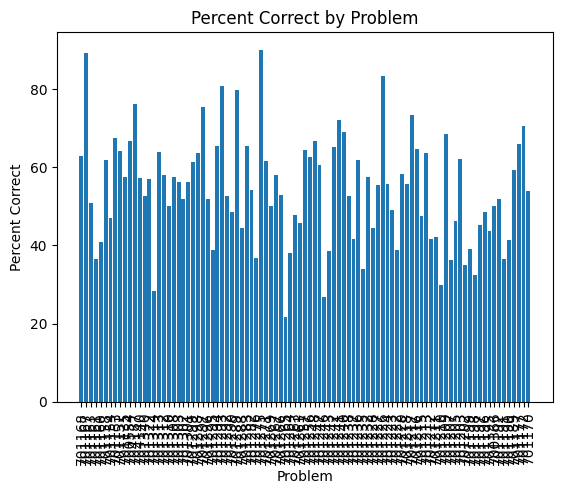

701168: 159
701167: 46
701163: 63
701161: 82
701160: 22
701158: 47
701154: 51
701153: 86
701151: 95
701135: 33
700554: 18
704187: 25
704140: 42
701340: 19
701322: 156
701314: 81
701313: 80
701312: 38
701310: 22
701308: 61
701303: 16
701302: 29
701301: 155
701299: 49
701298: 77
701297: 73
701296: 79
701295: 49
701294: 26
701293: 31
701292: 38
701290: 64
701289: 79
701288: 164
701283: 81
701282: 48
701276: 30
701275: 10
701271: 52
701269: 16
701267: 19
701266: 34
701265: 23
701264: 21
701263: 21
701261: 46
701257: 42
701256: 24
701248: 12
701247: 43
701246: 15
701243: 39
701242: 23
701241: 61
701240: 45
701238: 55
701237: 89
701236: 42
701235: 68
701232: 33
701228: 54
701227: 74
701226: 36
701224: 36
701223: 53
701222: 93
701220: 72
701218: 90
701217: 153
701216: 62
701215: 76
701213: 96
701212: 36
701211: 50
701210: 94
701209: 35
701208: 0
701207: 44
701205: 39
701204: 0
701203: 103
701202: 60
701199: 23
701198: 34
701197: 64
701196: 33
701195: 64
700366: 16
701192: 54
701191: 63
701190

In [6]:
problemsResults = {}


for problem in problems:
    #problemResults[problem] = [correctInt, incorrectInt]
    problemsResults[problem] = {}
    problemsResults[problem]['correct'] = 0
    problemsResults[problem]['incorrect'] = 0
    problemsResults[problem]['indiffrent'] = 0
    problemsResults[problem]['total'] = len(problems[problem])
    problemsResults[problem]['correctPercent'] = 0
    problemsResults[problem]['correctFromSolvedPercent'] = 0

    good = 0
    bad = 0
    for user in problems[problem]:
        if (testUser(problems[problem][user])):
            good += 1
            problemsResults[problem]['correct'] += 1
        elif (testUser(problems[problem][user]) == False):
            bad += 1
            problemsResults[problem]['incorrect'] += 1
        else:
            problemsResults[problem]['indiffrent'] += 1
    try:
        problemsResults[problem]['correctPercent'] = problemsResults[problem]['correct'] / problemsResults[problem]['total'] * 100
        problemsResults[problem]['correctFromSolvedPercent'] = problemsResults[problem]['correct'] / (problemsResults[problem]['correct'] + problemsResults[problem]['incorrect']) * 100
    except:
        problemsResults[problem]['correctPercent'] = 0
        problemsResults[problem]['correctFromSolvedPercent'] = 0

print (problemsResults)

#bar graph of presentages
x = []
y = []
for problem in problemsResults:
    if problemsResults[problem]['correctPercent'] == 0:
        continue
    x.append(problem)
    y.append(problemsResults[problem]['correctFromSolvedPercent'])
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Percent Correct')
plt.xlabel('Problem')
plt.title('Percent Correct by Problem')
plt.show()

#print all lengths
for problem in problems:
    print (problem + ': ' + str(problemsResults[problem]['correct'] + problemsResults[problem]['incorrect']))

#print how many are above 50%
above50 = 0
below50 = 0
at50 = 0

avgAbove50 = 0
avgBelow50 = 0
for problem in problems:
    
    
    if (problemsResults[problem]['correctFromSolvedPercent'] == 0):
        pass
    elif problemsResults[problem]['correctFromSolvedPercent'] > 50:
        above50 += 1
        avgAbove50 += problemsResults[problem]['correctFromSolvedPercent']
    elif problemsResults[problem]['correctFromSolvedPercent'] < 50:
        below50 += 1
        avgBelow50 += problemsResults[problem]['correctFromSolvedPercent']
    elif problemsResults[problem]['correctFromSolvedPercent'] == 50:
        at50 += 1
    

        

avgAbove50 = avgAbove50 / above50
avgBelow50 = avgBelow50 / below50


print ('Above 50%: ' + str(above50))
print ('Below 50%: ' + str(below50))
print ('At 50%: ' + str(at50))
print ('Avg Above 50%: ' + str(avgAbove50))
print ('Avg Below 50%: ' + str(avgBelow50))
print ('Total: ' + str(above50 + below50))





Above 50%: 57
Below 50%: 35
At 50%: 6
Avg Above 50%: 63.028547809583586
Avg Below 50%: 37.49825924390323
Total: 92


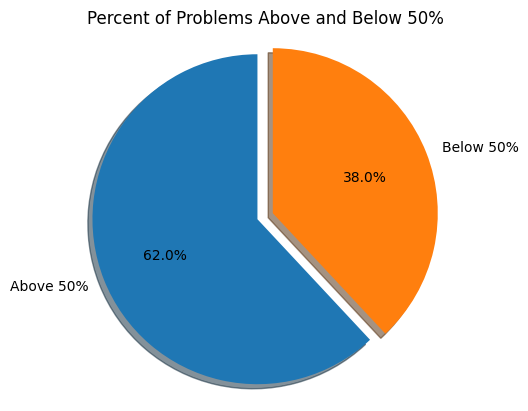

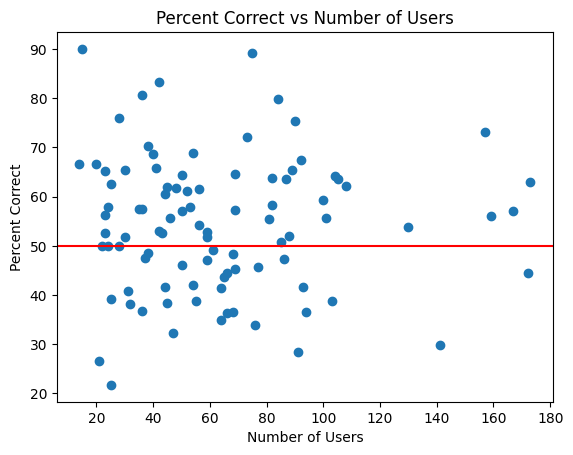

In [7]:
above50=0
below50=0
avgAbove50 = 0
avgBelow50 = 0
for problem in problems:
    if problemsResults[problem]['correctFromSolvedPercent'] > 50:
        above50 += 1
        avgAbove50 += problemsResults[problem]['correctFromSolvedPercent']
    elif problemsResults[problem]['correctFromSolvedPercent'] < 50:
        below50 += 1
        avgBelow50 += problemsResults[problem]['correctFromSolvedPercent']
    else:
        at50 += 1

avgAbove50 = avgAbove50 / above50
avgBelow50 = avgBelow50 / below50


print ('Above 50%: ' + str(above50))
print ('Below 50%: ' + str(below50))
print ('At 50%: ' + str(at50))
print ('Avg Above 50%: ' + str(avgAbove50))
print ('Avg Below 50%: ' + str(avgBelow50))
print ('Total: ' + str(above50 + below50))

#Generate a pie chart of the number of problems above 50% and below 50%
labels = 'Above 50%', 'Below 50%'
sizes = [above50, below50]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Percent of Problems Above and Below 50%')
plt.show()

#Generate a plot chart for number of users vs percent correct
x = []
y = []
for problem in problemsResults:
    if problemsResults[problem]['correctFromSolvedPercent'] == 0:
        continue
    x.append(problemsResults[problem]['total'])
    y.append(problemsResults[problem]['correctFromSolvedPercent'])
plt.plot(x, y, 'o')
plt.ylabel('Percent Correct')
plt.xlabel('Number of Users')
plt.title('Percent Correct vs Number of Users')
#draw a line at 50%
plt.axhline(y=50, color='r', linestyle='-')
plt.show()
